# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import re
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from numpy.random import RandomState
from scipy import stats

%matplotlib inline


from collections import defaultdict
import os
import time
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error as mse
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

PATH = '/datasets/'
SEED = 21

### Изучение данных

In [2]:
file_path = "/datasets/autos.csv"
data = pd.read_csv(file_path)
display(data.head(10))
print(data.info())
print('Количество дубликатов:', sum(data.duplicated()))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


- Признаки NumberOfPictures, PostalCode не несут полезной информации, удалим их.
- Также DateCrawled повторяет дату в признаке DateCreated.
- Признак Brand скорее всего будет лишним при наличии конкретной модели автомобиля в признаке Model.
- RegistrationMonth распределён равномерно и по смыслу вряд ли влияет на цену автомобиля.
- Избавимся от дублированний и неинформативных признак

Построим распределения данных в числовых признаках и на их зависимости от целевого признака price

In [4]:
#sns.pairplot(data)

### Предобработка данных

Удаляем дубликаты:

In [5]:
data = data.drop_duplicates()

In [6]:
data.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Проверим нулевые значения:

#### Price 

In [7]:
len(data.loc[data['Price'] == 0])

10772

В 10771 объявлении продавцы не указали цену. Заполнение данных значений по моему мнению снизит точность предсказаний. Удаляю их

In [8]:
len(data.loc[data['Price'] == 0]) / len(data.loc[data['Price'] != 0])

0.03135104615053275

Данные значения составляют 3% от выборки

In [9]:
data = data.loc[data['Price'] != 0]

<AxesSubplot:xlabel='Price', ylabel='Count'>

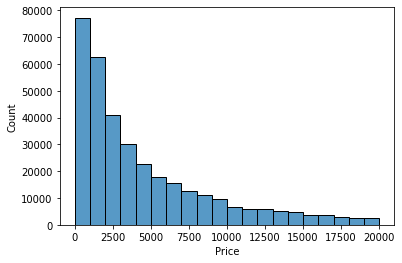

In [10]:
sns.histplot(data['Price'], bins=20)

#### Model

In [11]:
len(data.loc[data['Model'].isna()])

17521

In [12]:
 len(data.loc[data['Model'].isna()]) /len(data.loc[data['Model'] != 'Nan'])

0.05099347192754218

Пропущено 5.1% данных. ДАнный признак сильно влияет на цену, его заполнение может стать причиной искажения предсказаний. Данные лучше удалить.

In [13]:
data = data.loc[~data['Model'].isna()]

#### Power

Так как средняя мощность автомобилей в России 117, предположим, что мощность более 1000л.с. - маловероятно, заменим значения модели и мощности медианными:

In [14]:
data.loc[(data['Power'] > 1000) | (data['Power'] <= 0), 'Power'] = None
data['Power'] = data['Power'].fillna(data.groupby('Model')['Power'].transform('median'))
data = data.loc[~data['Power'].isna()]
data['Power'] = data['Power'].astype('int64')

<AxesSubplot:xlabel='Power', ylabel='Count'>

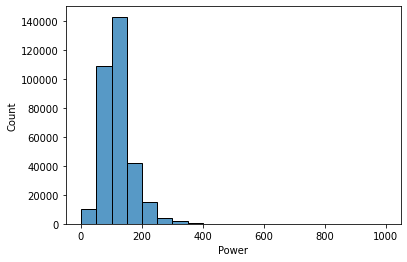

In [15]:
sns.histplot(data['Power'], bins=20)

<AxesSubplot:xlabel='Power', ylabel='Price'>

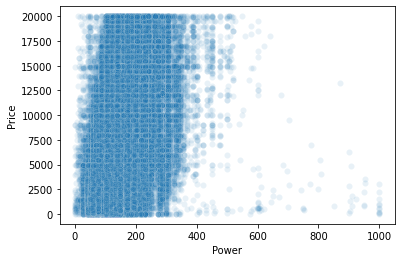

In [16]:
sns.scatterplot(x='Power', y='Price', data=data, alpha = 0.1)

#### Признаки DateCreated и LastSeen

Найдем дату самого первого объявления:

In [17]:
min(data['DateCreated'])

'2014-03-10 00:00:00'

Признаки DateCreated и LastSeen преобразуем в количество дней с момента 2014-03-01.

In [18]:
base_date = pd.Timestamp('2014-03-01 00:00:00')
data['DateCreated'] = data['DateCreated'].map(lambda date : (pd.Timestamp(date) - base_date).days)

In [19]:
data['LastSeen'] = data['LastSeen'].map(lambda date : (pd.Timestamp(date) - base_date).days)

#### Признак RegistrationYear

Отберем некорректно указанный год регистрации:

In [20]:
len(data.loc[data['RegistrationYear'] > 2020])

58

In [21]:
data.loc[data['RegistrationYear'] > 2020].head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
12946,2016-03-29 18:39:40,49,NaN,5000,NaN,101,golf,5000,12,NaN,volkswagen,NaN,759,0,74523,767
17271,2016-03-23 16:43:29,700,NaN,9999,NaN,116,other,10000,0,NaN,opel,NaN,753,0,21769,766
18259,2016-03-16 20:37:54,300,NaN,2200,NaN,58,twingo,5000,12,NaN,renault,NaN,746,0,45307,768
26382,2016-03-07 20:50:57,150,NaN,3000,NaN,95,a_klasse,5000,0,NaN,mercedes_benz,NaN,737,0,28217,738
26560,2016-03-24 17:45:47,800,NaN,2066,NaN,125,zafira,5000,0,gasoline,opel,NaN,754,0,45355,759
28390,2016-04-05 08:57:08,799,NaN,9999,NaN,150,3er,10000,4,petrol,bmw,NaN,766,0,72116,768
28965,2016-04-04 22:54:47,18000,NaN,9999,NaN,95,a_klasse,10000,0,petrol,mercedes_benz,NaN,765,0,51379,768
29426,2016-03-23 21:52:25,7999,NaN,9999,NaN,44,kaefer,10000,0,NaN,volkswagen,NaN,753,0,47638,767
40954,2016-03-07 14:48:23,59,NaN,8000,NaN,116,other,10000,0,NaN,chevrolet,NaN,737,0,31061,768
45662,2016-03-23 17:40:00,999,NaN,9000,NaN,69,fiesta,10000,0,NaN,ford,yes,753,0,50733,766


Данные внесут путаницу в модель, так как цена, с неправильным годом регистрации только испортит статистику. Данные удаляем.

In [22]:
data = data.loc[data['RegistrationYear'] <= 2020]

#### Признаки VehicleType, Gearbox, FuelType

Данные параметры c большой вероятностью одинаковы в одинаковых моделях автомобилей. Заполним пропуски в данных признаках наиболее частым значением той же модели.

In [23]:
data['VehicleType'] = data['VehicleType'].fillna(data
                                                  .groupby('Model')['VehicleType']
                                                  .transform(lambda x: x.value_counts().idxmax())
                                                 )

In [24]:
data['Gearbox'] = data['Gearbox'].fillna(data
                                                  .groupby('Model')['Gearbox']
                                                  .transform(lambda x: x.value_counts().idxmax())
                                                 )

In [25]:
data['FuelType'] = data['FuelType'].fillna(data
                                           .groupby('Model')['FuelType']
                                           .transform(lambda x: x.value_counts().idxmax())
                                          )

In [26]:
data['FuelType'].value_counts()

petrol      221458
gasoline     98790
lpg           4845
cng            533
hybrid         204
other          118
electric        65
Name: FuelType, dtype: int64

#### Признак NotRepaired

In [27]:
data['NotRepaired'] = data['NotRepaired'].fillna('unknown')

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326013 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        326013 non-null  object
 1   Price              326013 non-null  int64 
 2   VehicleType        326013 non-null  object
 3   RegistrationYear   326013 non-null  int64 
 4   Gearbox            326013 non-null  object
 5   Power              326013 non-null  int64 
 6   Model              326013 non-null  object
 7   Kilometer          326013 non-null  int64 
 8   RegistrationMonth  326013 non-null  int64 
 9   FuelType           326013 non-null  object
 10  Brand              326013 non-null  object
 11  NotRepaired        326013 non-null  object
 12  DateCreated        326013 non-null  int64 
 13  NumberOfPictures   326013 non-null  int64 
 14  PostalCode         326013 non-null  int64 
 15  LastSeen           326013 non-null  int64 
dtypes: int64(9), object(

Выделим целевое значение и признаки

Разобьем данные на train и test, в соотношении 4 к 1

Train дополнительно разобьем на train_valid и valid, так же в соотношении 4 к 1

In [29]:
col_to_drop = ['DateCrawled', 'LastSeen', 'DateCreated', 'NumberOfPictures']
data = data.drop(columns=col_to_drop)

cat_col = ['VehicleType', 'Gearbox', 'Model', 'FuelType',
           'Brand', 'RegistrationMonth', 'NotRepaired']

In [30]:
data[cat_col] = data[cat_col].fillna('Nan')

In [31]:
X = data.drop(columns='Price')
y = data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
#X_train_valid, X_valid, y_train_valid, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=21)

#print('Valid shapes:')
#print(X_train_valid.shape, X_valid.shape, y_train_valid.shape, y_valid.shape)
print('Train/test shapes:')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Train/test shapes:
(260810, 11) (65203, 11) (260810,) (65203,)


## Обучение моделей

Действовать будем по следующему плану:

Напишем функцию которой на вход будут подаваться модель и датасеты и она будет возвращать время обучения, время предсказания и rmse
Проверим 3 модели: Ridge, CatBoost, LightGBM.
Для каждой моделии найдем лучшие гиперпараметры, и измерим время обучения на train
Сведем данные по всем моделям в 1 таблицу

In [32]:
def model_eval(model, X_train, y_train, X_test, y_test):
    
    start = time.time()    
    model.fit(X_train, y_train)
    training_time = time.time() - start
    
    start = time.time()  
    y_pred = model.predict(X_test)
    predict_time = time.time() - start

    return training_time, predict_time, mse(y_test, y_pred)**0.5


**Ridge**


- Подготовим пайплайн: OHE -> scaler -> ridge
- На кросс валидации найдем лучшие параметры модели
- Измерим время обучения и запишем результаты на тесте.

In [33]:
res = []

In [34]:
pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', Ridge(random_state=SEED))
])

params = [
    {
        'model__alpha': np.logspace(-2, 2, 20)
    } 
]

In [35]:
cv = KFold(n_splits=3, shuffle=True, random_state=SEED)

grid = GridSearchCV(pipe,
                    param_grid=params,
                    cv=cv,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    verbose=False)

In [36]:
%%time
grid.fit(X_train, y_train);

CPU times: user 40.4 s, sys: 2.36 s, total: 42.7 s
Wall time: 43 s


GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             estimator=Pipeline(steps=[('ohe',
                                        OneHotEncoder(handle_unknown='ignore')),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('model', Ridge(random_state=21))]),
             n_jobs=-1,
             param_grid=[{'model__alpha': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02])}],
             scoring='neg_mean_squared_error', verbose=False)

In [37]:
grid.best_params_

{'model__alpha': 37.92690190732246}

In [38]:

res.append(model_eval(grid.best_estimator_, X_train, y_train, X_test, y_test))

**LightGBM**

- Готовим категориальные признаки через Label Encoder
- Ищем лучшие параметры по сетке используя Scikit-learn API
- Обучаем модель на всей train выборке и замеряем время и RMSE

In [39]:
lgb_train = X_train.copy()
lgb_test = X_test.copy()


cat_col_num = []

for col in cat_col:
    lgb_train[col] = lgb_train[col].astype('category')
    lgb_test[col] = lgb_test[col].astype('category')
    cat_col_num.append(data.columns.to_list().index(col))

gbm = lgb.LGBMRegressor(boosting_type='gbdt', verbose=0, seed=SEED)


params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'n_estimators': [40, 60],
    'num_leaves': [21, 31, 41],
}

grid_gbm = GridSearchCV(gbm,
                        params,
                        cv=cv,
                        scoring='neg_mean_squared_error',
                        verbose=True)

In [40]:
%%time
grid_gbm.fit(lgb_train, y_train);

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Au

GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             estimator=LGBMRegressor(seed=21, verbose=0),
             param_grid={'learning_rate': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ]),
                         'n_estimators': [40, 60], 'num_leaves': [21, 31, 41]},
             scoring='neg_mean_squared_error', verbose=True)

In [41]:
grid_gbm.best_params_

{'learning_rate': 0.1778279410038923, 'n_estimators': 60, 'num_leaves': 41}

In [42]:
res.append(model_eval(grid_gbm.best_estimator_, lgb_train, y_train, lgb_test, y_test))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


**CatBoost**

In [43]:
cbr = CatBoostRegressor(random_seed=SEED,
                        loss_function='RMSE',
                        silent=True,
                        cat_features=cat_col)

params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'iterations': [40, 60],
    'depth': [6, 8, 10],
}

grid_cbr = GridSearchCV(cbr,
                        params,
                        cv=cv,
                        scoring='neg_mean_squared_error',
                        verbose=False)

In [44]:
%%time
grid_cbr.fit(X_train, y_train);

CPU times: user 7min 4s, sys: 2.25 s, total: 7min 6s
Wall time: 8min 11s


GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fc8ea823eb0>,
             param_grid={'depth': [6, 8, 10], 'iterations': [40, 60],
                         'learning_rate': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ])},
             scoring='neg_mean_squared_error', verbose=False)

In [45]:
grid_cbr.best_params_

{'depth': 10, 'iterations': 60, 'learning_rate': 0.1778279410038923}

In [46]:
res.append(model_eval(grid_cbr.best_estimator_, X_train, y_train, X_test, y_test))

## Анализ моделей

Сведем все данные в один датафрейм и посмотрим результаты на валидационной выборке

Для выбранной модели посмотрим результат на тесте

In [47]:
res

[(0.8140840530395508, 0.12045121192932129, 2054.4919742482844),
 (5.089848041534424, 0.49625539779663086, 1643.795699281927),
 (10.224634885787964, 0.10201239585876465, 1712.0489852743626)]

In [48]:
pd.DataFrame(data=res,
             index=['Ridge', 'LightGBM', 'CatBoost'],
             columns=['training_time', 'predic_time', 'score'])

,training_time,predic_time,score
Ridge,0.814084,0.120451,2054.491974
LightGBM,5.089848,0.496255,1643.795699
CatBoost,10.224635,0.102012,1712.048985


Быстрее всего работает Ringe, однако качество ниже всего. В данном случае наиболее подходящей моделью, с оптимальным качеством и быстродействием оказался: LightGBM.

Проверим метрику на тесте

In [49]:
model = gbm
model.fit(lgb_train, y_train)
mse(y_test, model.predict(lgb_test))**0.5

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.395463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


1659.3156912137158